# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [ ]:
###env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64", no_graphics=False)
###env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64", no_graphics=True)
env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64") #suggested by Udacity

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.visual_observations[0]

print('States look like:')
plt.imshow(np.squeeze(state, axis=0))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)
#print(np.expand_dims(state, axis=4).shape) #this is unsqueeze
state = state.reshape((-1,3,84,84))
print('modified state is: ', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    #print(done)
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [ ]:
#Training the agent
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
import torch
import pickle
from pixel_dqn_agent import Agent

local_network_fn = './saved_agent/dqn_checkpoint_local.pth'
target_network_fn = './saved_agent/dqn_checkpoint_target.pth'
memory_buffer_fn = './saved_agent/memory_buffer'
scores_fn = './saved_agent/scores.txt'
#agent_fn = 'ddqn_checkpoint_agent.pth'
def load_agent(agent):    
    agent.qnetwork_local.load_state_dict(torch.load(local_network_fn, map_location=lambda storage, loc: storage))
    agent.qnetwork_target.load_state_dict(torch.load(target_network_fn, map_location=lambda storage, loc: storage))
    with open(scores_fn, "rb") as sf:
        agent.scores = pickle.load(sf)
    with open(memory_buffer_fn, "rb") as mf:
        agent.memory.memory = pickle.load(mf)
    #agent = Agent.load(agent_fn)
    return agent

def save_agent(agent):    
    torch.save(agent.qnetwork_local.state_dict(), local_network_fn)
    torch.save(agent.qnetwork_target.state_dict(), target_network_fn)
    with open(scores_fn, "wb") as sf:
        pickle.dump(agent.scores, sf, pickle.HIGHEST_PROTOCOL)
    with open(memory_buffer_fn, "wb") as mf:
        mem_to_save = deque(list(agent.memory.memory)[-50000:], maxlen=100000) #agent.memory.memory
        pickle.dump(mem_to_save, mf, pickle.HIGHEST_PROTOCOL)
    #agent.save(agent_fn)
    return None

def train_agent():
    env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64", seed=111)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    final_eps = 0.01
    eps_start= 1.0 #0.01 #1.0
    agent = Agent(num_input_chnl=11, action_size=4, seed=0) #create a new agent
    #agent = load_agent(agent)
  
    def dqn(n_episodes=3000, max_t=1000, eps_start=eps_start, eps_end=final_eps, eps_decay=0.995):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name] # reset the environment
            state = env_info.visual_observations[0]            # get the current state
            #print(type(state))
            state = state.reshape((-1,3,84,84))
            #state = np.expand_dims(state, axis=0)
            #print(state.shape)
            #state = torch.from_numpy(state)
            score = 0                                          # initialize the score
            for t in range(max_t): #this could also be while True instead
                aug_state = agent.augment_state(state)         # augment the state
                action = agent.act(aug_state, eps)             # select an action using e-greedy policy
                env_info = env.step(action)[brain_name]        # send the action to the environment
                next_state = env_info.visual_observations[0]   # get the next state
                next_state = next_state.reshape((-1,3,84,84))
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]                  # see if episode has finished
                agent.step(state, action, reward, next_state, done, is_training=True) #add to experience buffer and do the learning

                score += reward                                # update the score
                state = next_state                             # roll over the state to next time step
                if done:                                       # exit loop if episode finished
                    break                

            scores_window.append(score)       # save most recent score
            agent.scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                print(len(agent.memory.memory), agent.memory.memory.maxlen)
            if i_episode % 500 == 0: #save weights every 500 episodes
                save_agent(agent)
            if np.mean(scores_window)>=17.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                save_agent(agent)
                break
        save_agent(agent) #save at the end

        return agent.scores


    strt = time.time()
    scores = dqn()
    print('\nTraining Time is {}'.format(time.time()-strt))
    env.close()

#     # plot the scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     plt.plot(np.arange(len(scores)), scores)
#     plt.ylabel('Score')
#     plt.xlabel('Episode #')
#     plt.show()


#Train the agent
print('Starting Agent Training:')
train_agent()

In [1]:
#Testing the agent
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
import torch
import pickle
from pixel_dqn_agent import Agent

local_network_fn = './saved_agent/dqn_checkpoint_local.pth'
def test_agent(num_episodes=10):
    #env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64", seed=111)
    env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64")
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    scores = []
    final_eps=0.01    
    agent = Agent(num_input_chnl=11, action_size=4, seed=0) #create a new agent
    agent.qnetwork_local.load_state_dict(torch.load(local_network_fn, map_location=lambda storage, loc: storage)) #load the weights
    
    for i_episode in range(1,num_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.visual_observations[0]            # get the current state
        state = state.reshape((-1,3,84,84))
        score = 0                                          # initialize the score
        while True:
            aug_state = agent.augment_state(state)         # augment the state
            action = agent.act(aug_state, final_eps)             # select an action using e-greedy policy
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.visual_observations[0]   # get the next state
            next_state = next_state.reshape((-1,3,84,84))
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done, is_training=False) #only add to experience buffer and don't do learning

            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                scores.append(score)
                print('Episode {}: {}'.format(i_episode, score))
                break
    env.close()
    return np.mean(scores)

print('Starting Agent Testing:')
num_episodes=1 #100
mean_score = test_agent(num_episodes)
print("Mean Score out of {} episodes is {}".format(num_episodes, mean_score))

Starting Agent Testing:


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 1: 11.0
Mean Score out of 1 episodes is 11.0


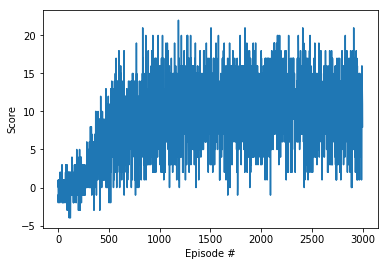

In [3]:
#Plot the learning behavior
import pickle
import matplotlib.pyplot as plt

with open('./saved_agent/scores.txt', 'rb') as f:
    scores = pickle.load(f)

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()